In [1]:
import json
import pandas as pd
import jmespath

In [2]:
with open('data/data_000.json') as f:
  rlist = json.load(f)

In [3]:
start_times = jmespath.search("[?seq_key=='IntroInstructions'].{sessionId: sessionId, route: route, timestamp: timestamp}", rlist)
end_times = jmespath.search("[?seq_key=='End'].{sessionId: sessionId, timestamp: timestamp}", rlist)

In [4]:
delta_dict = {'sessionId': [], 'condition': [], 'time_delta': []}
for x in start_times:
    if 'test' not in x['sessionId'] and x['timestamp'] > 1606754513706:
        start_time = pd.Timestamp(x['timestamp'], unit='ms')
        search_end = jmespath.search(f"[?sessionId=='{x['sessionId']}']", end_times)
        if search_end:  # not empty
            assert len(search_end) == 1
            end_time = pd.Timestamp(search_end[0]['timestamp'], unit='ms')
            time_delta = end_time - start_time
            delta_dict['sessionId'].append(x['sessionId'])
            delta_dict['condition'].append(int(x['route'][-1]))
            delta_dict['time_delta'].append(time_delta)

In [5]:
delta_df = pd.DataFrame(delta_dict)

In [6]:
# even conditions are active in both training and testing
delta_df[delta_df.condition%2 == 0].time_delta.mean()

Timedelta('0 days 00:06:56.210285714')

In [7]:
results_dict = {'condition': [], '0_rating_train': [], '1_rating_train': [], '2_rating_train': [], 'how_train': [], 'strategy_train': [], '0_rating_test': [], '1_rating_test': [], '2_rating_test': [], 'how_test': [], 'strategy_test': []}
for x in rlist:
    if 'test' not in x['sessionId'] and x['timestamp'] > 1606754513706:
        condition_num = int(x['route'][-1])
        if x['seq_key'] == 'End':
            results_dict['condition'].append(condition_num)

            if condition_num == 2 or condition_num == 3:  # disjunctive
                # TODO: don't use different train test key names next time
                train_blocks = x['blocks']['disj_train']
                test_blocks = x['blocks']['disj_test']
                train_quiz = x['quiz_data']['disj_train']
                test_quiz = x['quiz_data']['disj_test']
            elif condition_num == 0 or condition_num == 1:  # conjunctive
                train_blocks = x['blocks']['conj_train']
                test_blocks = x['blocks']['conj_test']
                train_quiz = x['quiz_data']['conj_train']
                test_quiz = x['quiz_data']['conj_test']
            
            for i in range(3):
                rating_field = str(train_blocks[i]['id']) + '_rating_train'
                rating = train_quiz['blicket_answer_groups'][i]
                results_dict[rating_field].append(rating)

                rating_field = str(test_blocks[i]['id']) + '_rating_test'
                rating = test_quiz['blicket_answer_groups'][i]
                results_dict[rating_field].append(rating)

            results_dict['how_train'].append(train_quiz['free_response_0'])
            results_dict['strategy_train'].append(train_quiz['free_response_1'])
            results_dict['how_test'].append(test_quiz['free_response_0'])
            results_dict['strategy_test'].append(test_quiz['free_response_1'])
            
        # print(x['sessionId'], condition_num, x['seq_key'])

In [8]:
results_df = pd.DataFrame(results_dict)

In [9]:
results_df.columns

Index(['condition', '0_rating_train', '1_rating_train', '2_rating_train',
       'how_train', 'strategy_train', '0_rating_test', '1_rating_test',
       '2_rating_test', 'how_test', 'strategy_test'],
      dtype='object')

In [10]:
results_df.to_csv('output/results_000.csv', index=False)

In [10]:
train_data_cols = ['0_rating_train', '1_rating_train', '2_rating_train']
test_data_cols = ['0_rating_test', '1_rating_test', '2_rating_test']

### conjunctive training

In [14]:
results_df[(results_df.condition == 0) | (results_df.condition == 1)][train_data_cols]

,0_rating_train,1_rating_train,2_rating_train
1,5,4,10
2,8,2,8
3,8,0,8
4,10,0,10
6,0,0,0
7,10,0,10


<AxesSubplot:>

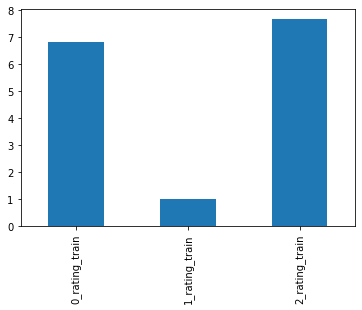

In [15]:
results_df[(results_df.condition == 0) | (results_df.condition == 1)][train_data_cols].mean().plot.bar()

### conjunctive testing

In [16]:
results_df[(results_df.condition == 0) | (results_df.condition == 1)][test_data_cols]

,0_rating_test,1_rating_test,2_rating_test
1,5,5,5
2,8,2,8
3,5,2,8
4,9,4,8
6,5,0,5
7,10,0,10


<AxesSubplot:>

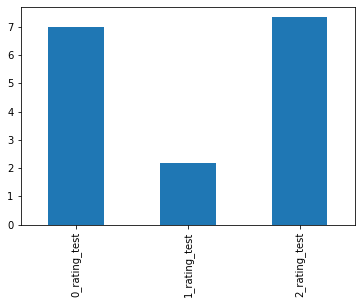

In [17]:
results_df[(results_df.condition == 0) | (results_df.condition == 1)][test_data_cols].mean().plot.bar()

### disjunctive training

In [18]:
results_df[(results_df.condition == 2) | (results_df.condition == 3)][train_data_cols]

,0_rating_train,1_rating_train,2_rating_train
0,10,0,0
5,10,0,0
8,10,5,5
9,10,0,0


<AxesSubplot:>

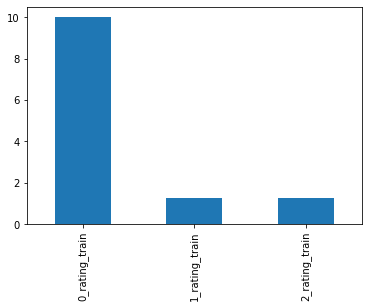

In [19]:
results_df[(results_df.condition == 2) | (results_df.condition == 3)][train_data_cols].mean().plot.bar()

### disjunctive testing

In [20]:
results_df[(results_df.condition == 2) | (results_df.condition == 3)][test_data_cols]

,0_rating_test,1_rating_test,2_rating_test
0,0,0,10
5,5,5,10
8,0,0,10
9,0,0,10


<AxesSubplot:>

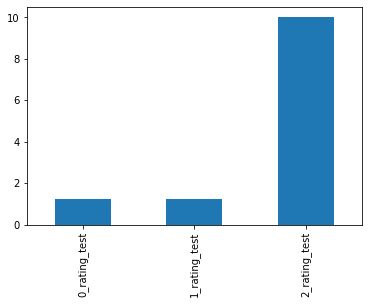

In [21]:
results_df[(results_df.condition == 2) | (results_df.condition == 3)][test_data_cols].mean().plot.bar()

## t testing that the active conj training is producing significant DEF results like Lucas and Griffiths (2010)

<AxesSubplot:>

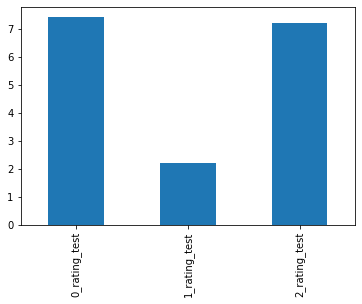

In [23]:
# condition 0: _active_ conjunctive training followed by passive DEF testing
results_df[(results_df.condition == 0)][test_data_cols].mean().plot.bar()  # test ratings

<AxesSubplot:>

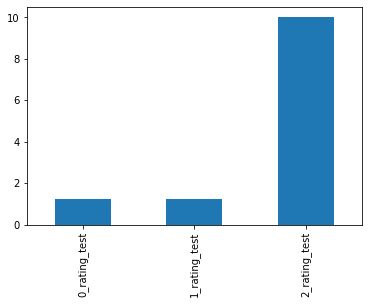

In [40]:
# condition 2 and 3: active or passive disjunctive training followed by passive DEF testing
results_df[(results_df.condition == 2) | (results_df.condition == 3)][test_data_cols].mean().plot.bar()  # test ratings

In [25]:
test_data_cols

['0_rating_test', '1_rating_test', '2_rating_test']

In [38]:
results_df[(results_df.condition == 2) | (results_df.condition == 3)]['0_rating_test']

0    0
5    5
8    0
9    0
Name: 0_rating_test, dtype: int64

In [37]:
results_df[(results_df.condition == 0)]['0_rating_test']

1     5
2     8
4     9
6     5
7    10
Name: 0_rating_test, dtype: int64

In [39]:
from scipy import stats

# D ratings for conjunctive vs disjunctive active training
conj = results_df[(results_df.condition == 0)]['0_rating_test']
disj = results_df[(results_df.condition == 2) | (results_df.condition == 3)]['0_rating_test']

ttest = stats.ttest_ind(conj, disj, equal_var=False)
ttest

Ttest_indResult(statistic=3.7976712547307963, pvalue=0.008247915224413904)